In [690]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [586]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        # Prepare df3/lookup for use
        
        # Make firt column lowercase
        df3['Exit Survey'] = df3['Exit Survey'].str.lower()
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Purchases'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='left')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge Spend and Lift to Lookup Tab;e
        lift_spend_df = pd.merge(lift_spend_df, df3[['Exit Survey','Airings']],left_on= ['Network'], right_on = ['Airings'], how='left')
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, on=['Year','Month','Exit Survey'], how='outer')
        monthly_stats['network_name'] = np.where(monthly_stats.TV_Network.isnull(),monthly_stats.Network,monthly_stats.TV_Network)
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Network','network_name','Purchases','Spend','Lift']]
        monthly_stats = monthly_stats[monthly_stats.Year.notna()]
        
        
        #monthly_stats['network_name'] = np.where(monthly_stats.TV_Network.isnull(),monthly_stats.Network,monthly_stats.TV_Network)
        
        return monthly_stats
    
    def get_metrics(self):
        # Get Monthly Stats Df
        monthly_stats = self.get_monthly_stats()
        
        # Compute Cost Per Visitor
        monthly_stats['cpv'] = np.where(monthly_stats.Spend.isnull(),0, np.where((monthly_stats.Purchases.isnull()),np.nan,(monthly_stats.Spend/monthly_stats.Purchases)))
        
        # Compute Conversion Rate 
        monthly_stats['conversion_rate'] = monthly_stats['Purchases']/monthly_stats['Lift']
        
        # Compute Cost Per Acquisition
        monthly_stats['cpa'] = np.where(monthly_stats.Spend.isnull(),0, np.where((monthly_stats.Purchases.isnull()),np.nan,(monthly_stats.Spend/monthly_stats.Purchases)))
        
        return monthly_stats

In [587]:
test = Final('Analyst_Dataset.xlsx')


In [588]:
monthly_stats = test.get_metrics()

<ipython-input-586-29466b6ca5c8>:60: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


In [589]:
monthly_stats

,Year,Quarter,Month,TV_Network,Network,network_name,Purchases,Spend,Lift,cpv,conversion_rate,cpa
0,2017,Q3,9,aapka_colors,NaN,aapka_colors,1.0,NaN,NaN,0.000000,NaN,0.000000
1,2017,Q3,9,baby_first,NaN,baby_first,1.0,NaN,NaN,0.000000,NaN,0.000000
2,2017,Q3,9,bloomberg,BLOM,bloomberg,1.0,4966.72,199.0,4966.720000,0.005025,4966.720000
3,2017,Q3,9,cbs_sports,NaN,cbs_sports,1.0,NaN,NaN,0.000000,NaN,0.000000
4,2017,Q3,9,cnbc,CNBC,cnbc,5.0,6481.42,406.0,1296.284000,0.012315,1296.284000
5,2017,Q3,9,cnn,CNN,cnn,13.0,9159.60,507.0,704.584615,0.025641,704.584615
6,2017,Q3,9,dish_network,DISH,dish_network,4.0,2513.09,976.0,628.272500,0.004098,628.272500
7,2017,Q3,9,diy,NaN,diy,2.0,NaN,NaN,0.000000,NaN,0.000000
8,2017,Q3,9,fox_news,NaN,fox_news,5.0,NaN,NaN,0.000000,NaN,0.000000
9,2017,Q3,9,fox_sports,FS1,fox_sports,1.0,4258.50,183.0,4258.500000,0.005464,4258.500000


# Cost Per Vistor 

The Cost Per Vistor is the total dollar amount spent per visit to a company's website/physical location. In order to compute the Cost Per Vistor, the number of visitors to a company website/physical location needs to be recorded. Company XYZ only has records from people who have made a purchase. If the number of survey recordings (which is also equivalent to the number of sales made) is used in place of total visits, the Cost Per Visit calculated will be incorrect. If the Cost Per Visit were to be computed with the existing data, it would be equivalent to the Cost Per Acquisition.

# Cost Per Acquisition

In [590]:
monthly_stats.head()

,Year,Quarter,Month,TV_Network,Network,network_name,Purchases,Spend,Lift,cpv,conversion_rate,cpa
0,2017,Q3,9,aapka_colors,NaN,aapka_colors,1.0,NaN,NaN,0.000,NaN,0.000
1,2017,Q3,9,baby_first,NaN,baby_first,1.0,NaN,NaN,0.000,NaN,0.000
2,2017,Q3,9,bloomberg,BLOM,bloomberg,1.0,4966.72,199.0,4966.720,0.005025,4966.720
3,2017,Q3,9,cbs_sports,NaN,cbs_sports,1.0,NaN,NaN,0.000,NaN,0.000
4,2017,Q3,9,cnbc,CNBC,cnbc,5.0,6481.42,406.0,1296.284,0.012315,1296.284


# Visualizations

In [755]:
def print_visuals(df, metrics):
    year_mons = []

    # Get number of plots need (one for each month of each year recorded)
    for year in monthly_stats['Year'].unique():
        for month in df[df['Year'] == year]['Month'].unique():
            year_mons.append([year, month])
            
    for metric in metrics:
        for i in range(len(year_mons)):
            # Create dataframe for plot
            vis_df = df[(df['Year'] == year_mons[i][0]) & (df['Month'] == year_mons[i][1])]
            # Sort values by metric
            vis_df = vis_df.sort_values(metric)
            # Clean Network Names
            vis_df.network_name = vis_df.network_name.map(lambda x: x.replace("_"," "))
            vis_df.network_name = vis_df.network_name.map(lambda x: x.title())
            # Create Plot
            plt.figure(figsize = (30,10))
            # Plot data
            sns.barplot(x='network_name',y=metric, data=vis_df, palette = ['crimson'])
            # CAP All Metric Name
            cap_metric = metric.replace("_"," ")
            cap_metric = metric.upper()
            # Get Month Name (String)
            datetime_object = datetime.datetime.strptime(str(year_mons[i][1]), "%m")
            month_name = datetime_object.strftime("%B")
            # Title
            plt.title(cap_metric +' - ' + month_name + ', ' + str(year_mons[i][0]) , fontsize=35)
            # X Axis Label
            plt.xlabel('Network', fontsize=24)
            # Y Axis Label
            plt.ylabel(cap_metric, fontsize=24)
            # X Ticks
            plt.xticks(fontsize=14, rotation=60)
            plt.yticks(fontsize=18)
    

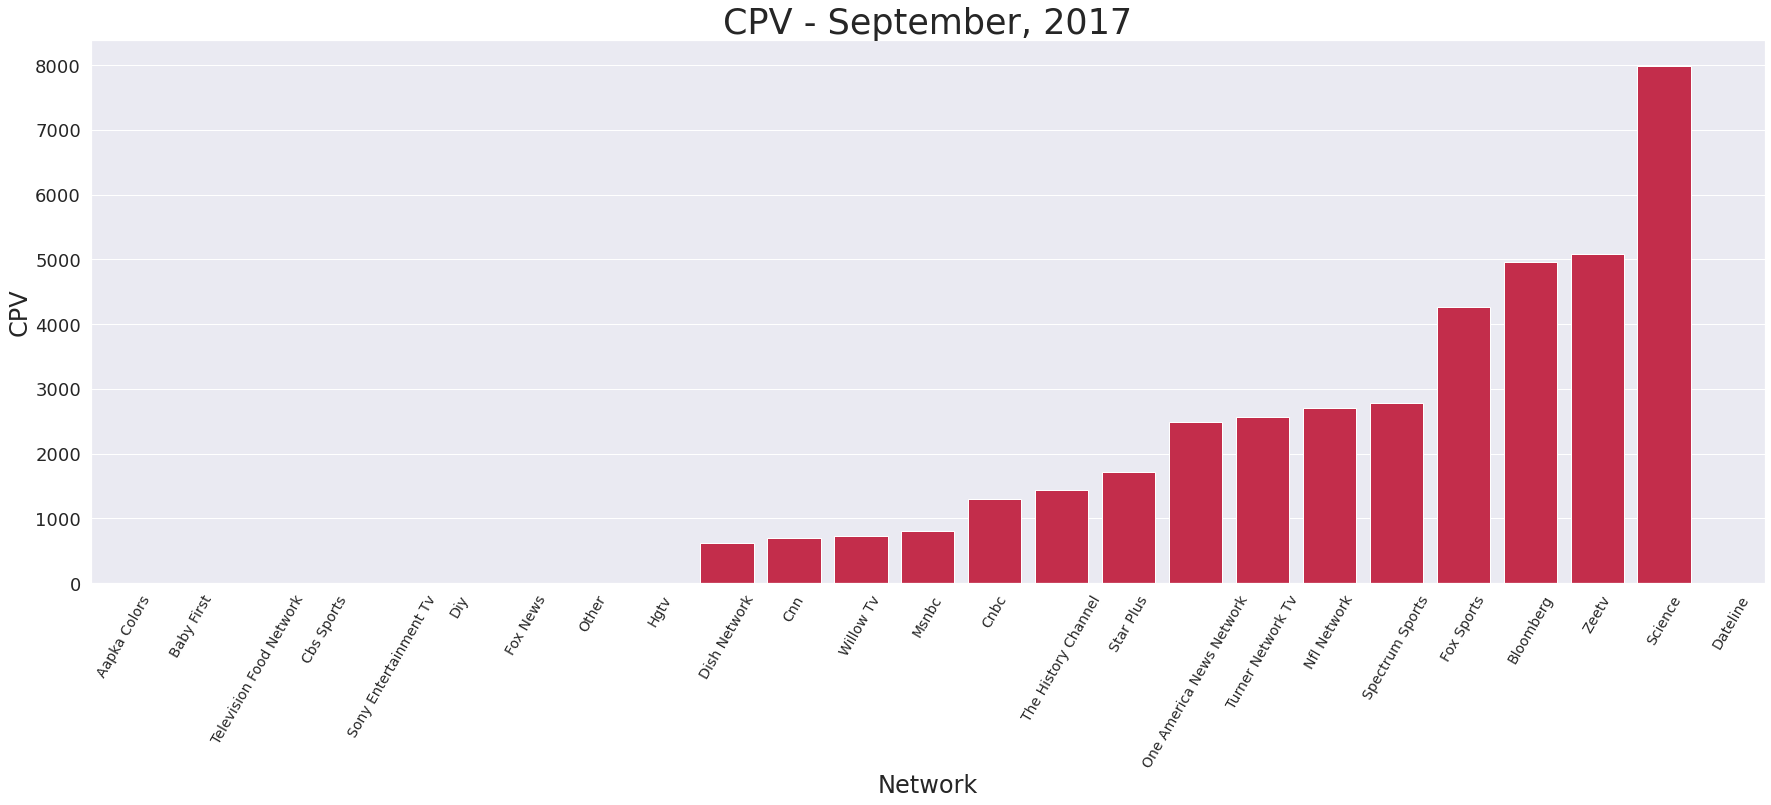

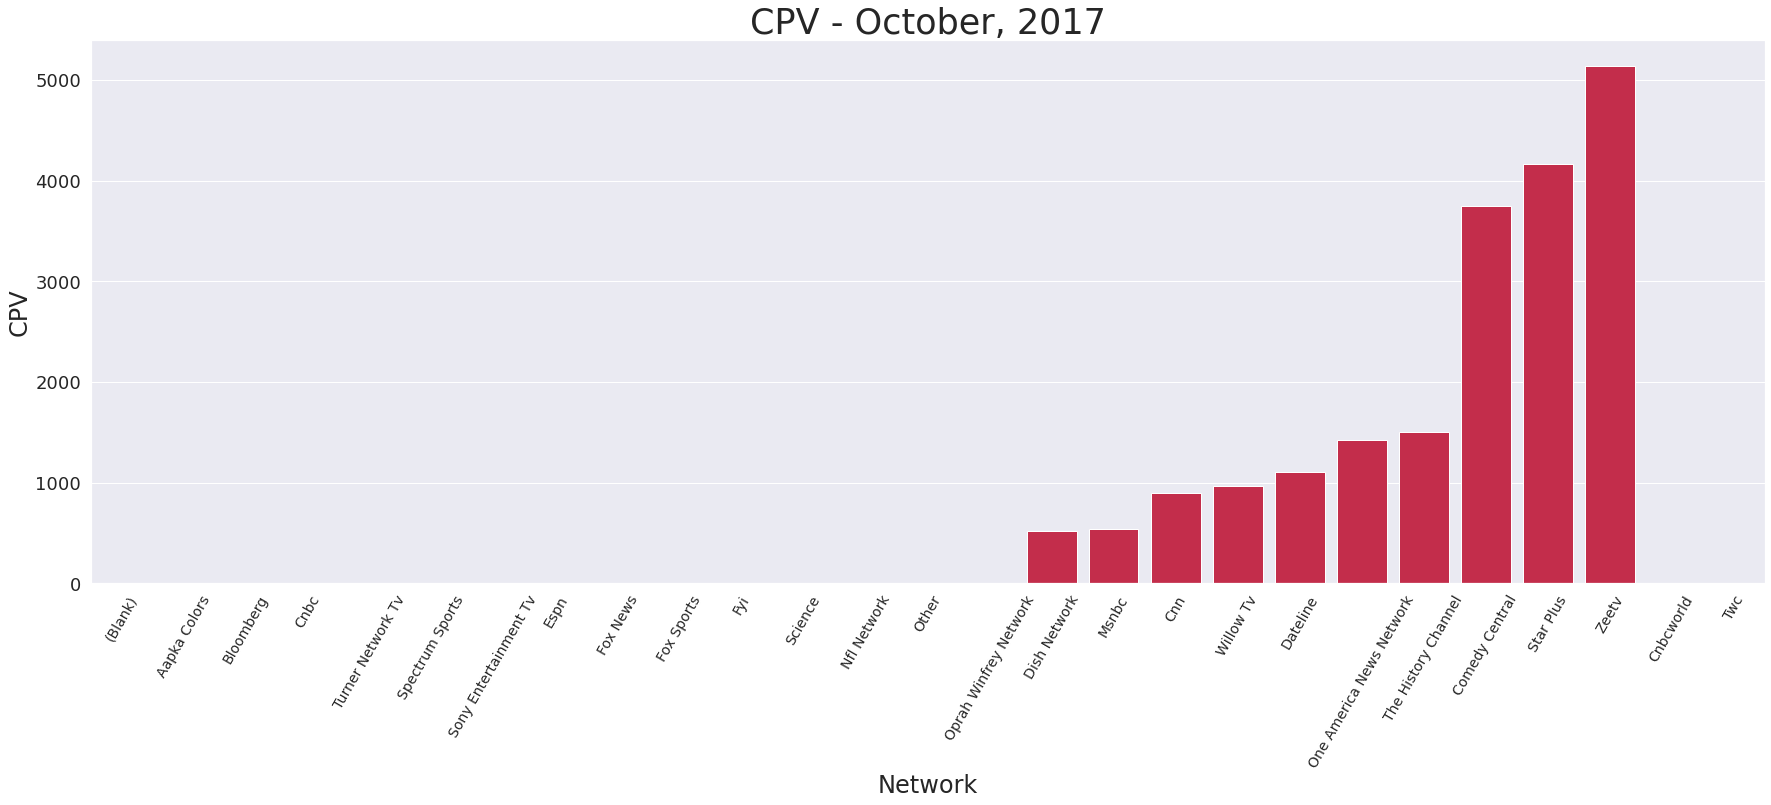

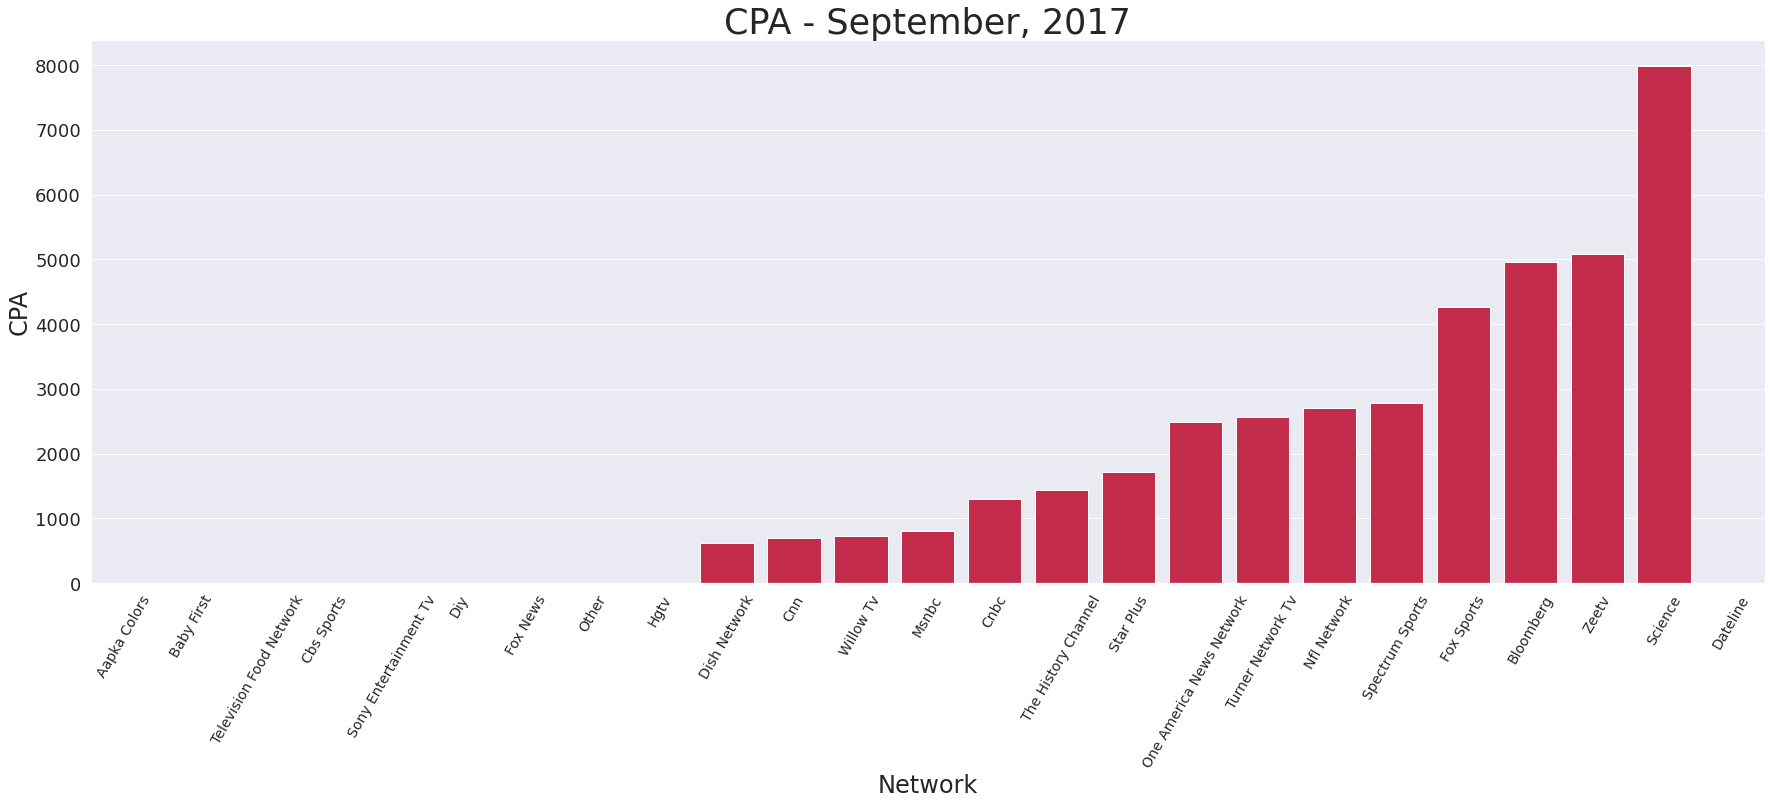

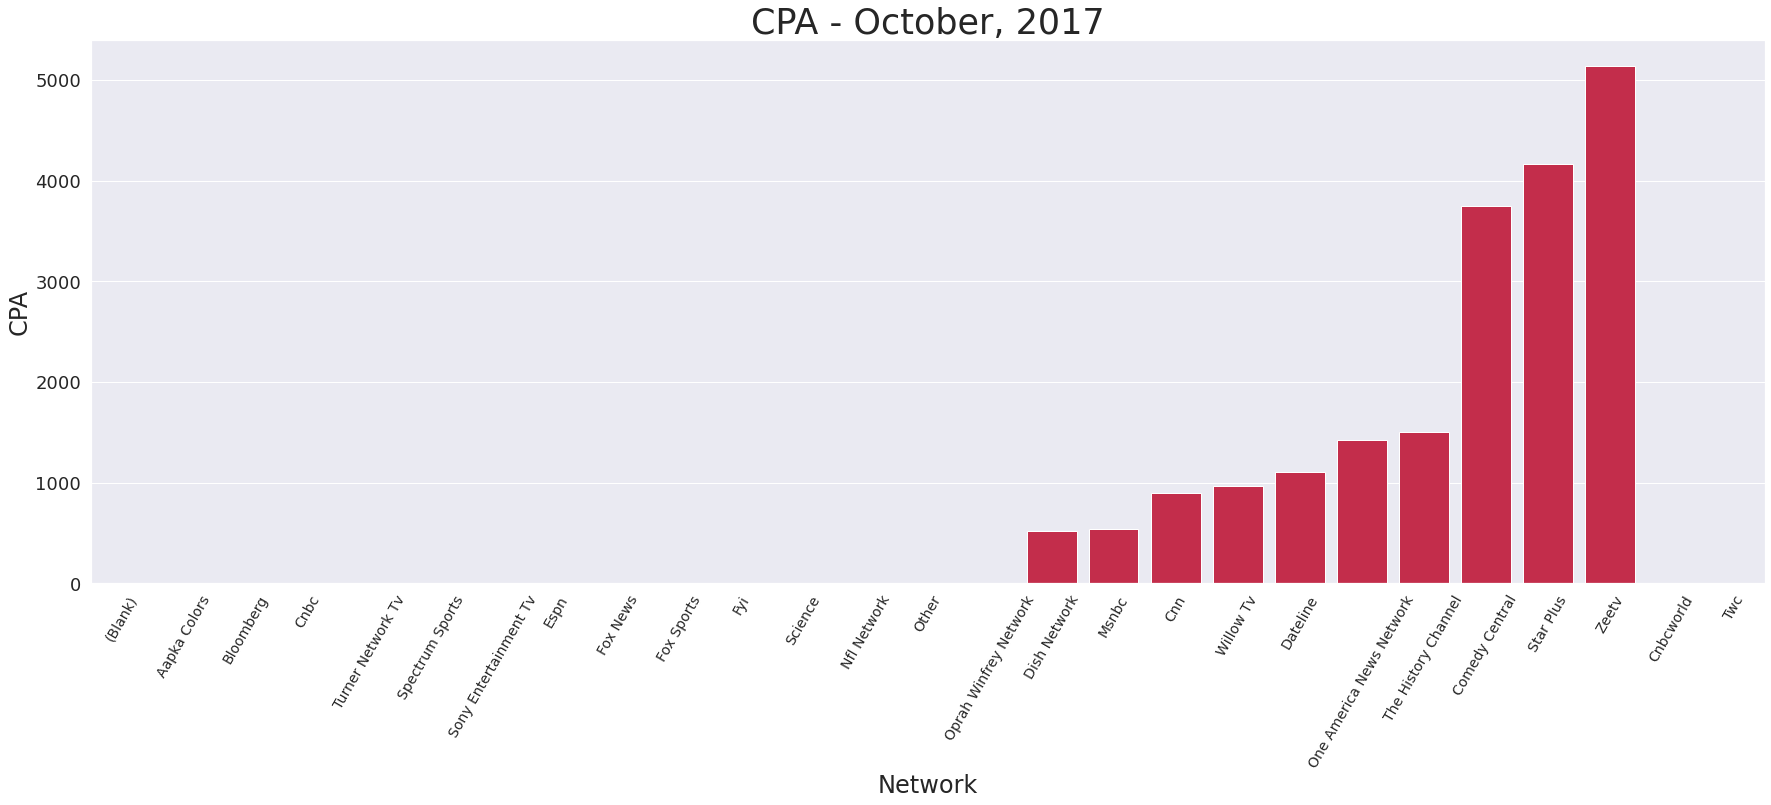

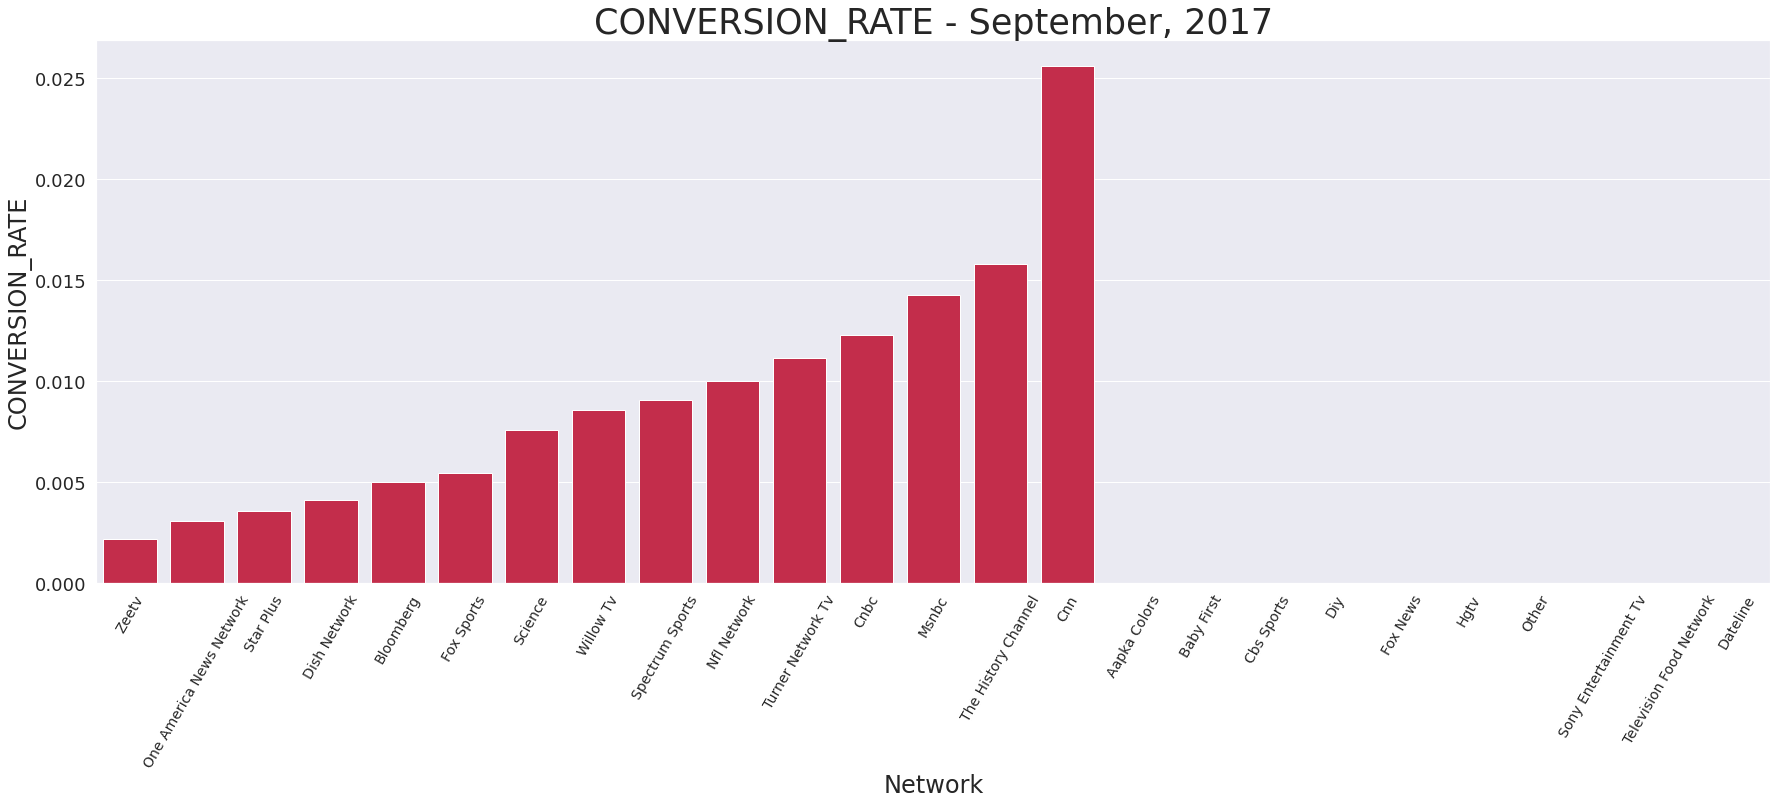

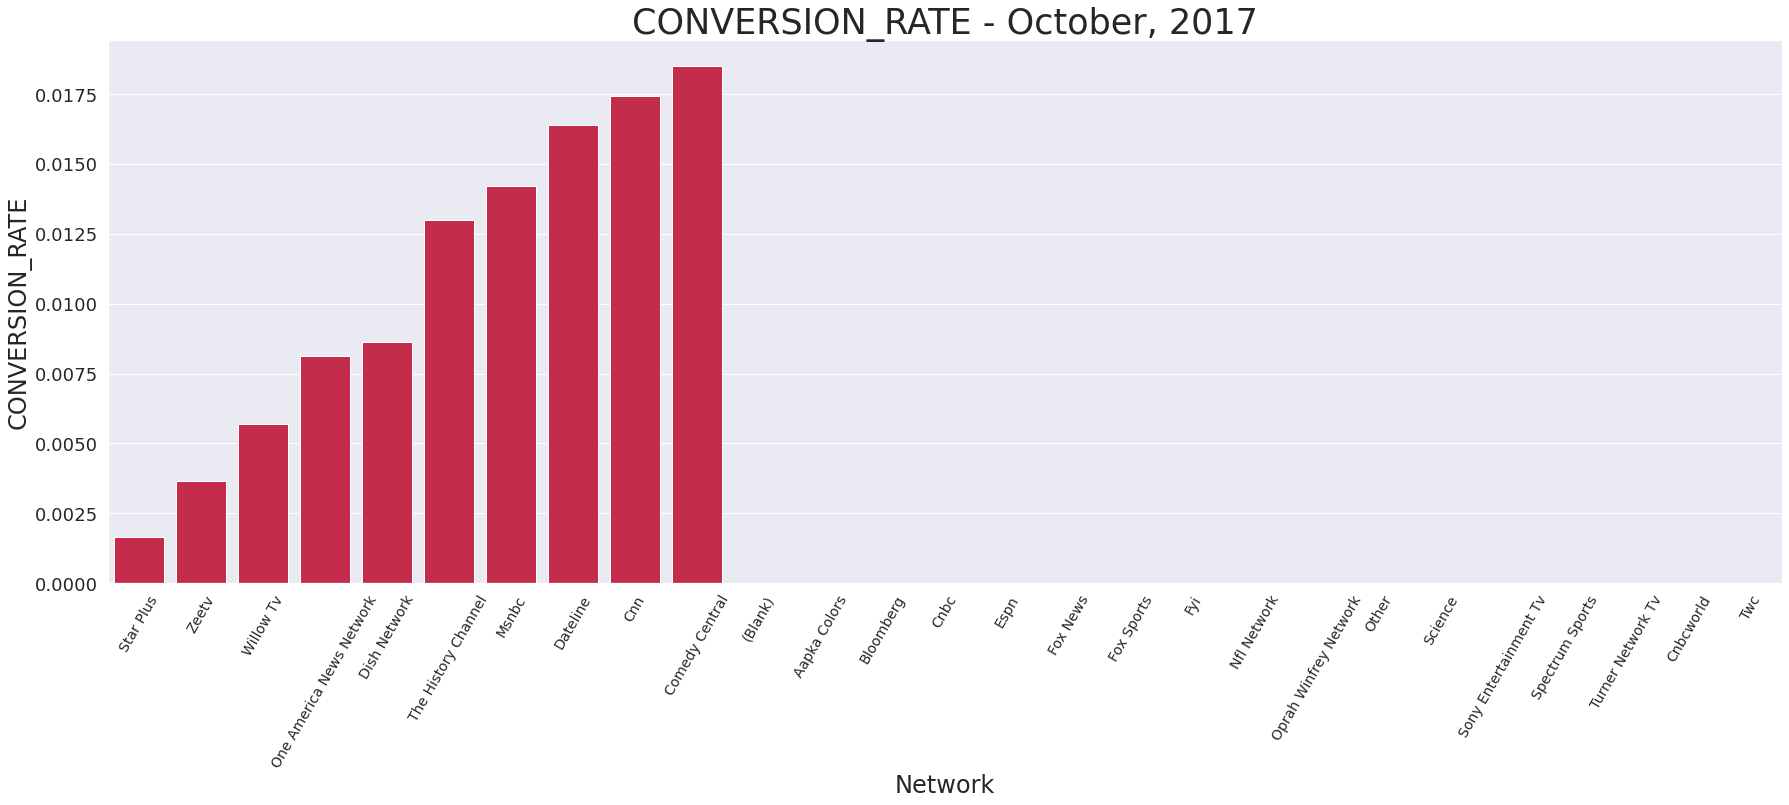

In [756]:
print_visuals(monthly_stats,['cpv','cpa','conversion_rate'])

In [765]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [786]:
def print_visuals(df, metrics):
    year_mons = []

    # Get number of plots need (one for each month of each year recorded)
    for year in monthly_stats['Year'].unique():
        for month in df[df['Year'] == year]['Month'].unique():
            year_mons.append([year, month])
            
    for metric in metrics:
        for i in range(len(year_mons)):
            # Create dataframe for plot
            vis_df = df[(df['Year'] == year_mons[i][0]) & (df['Month'] == year_mons[i][1])]
            # Sort values by metric
            vis_df = vis_df.sort_values(metric)
            # Clean Network Names
            vis_df.network_name = vis_df.network_name.map(lambda x: x.replace("_"," "))
            vis_df.network_name = vis_df.network_name.map(lambda x: x.title())
            # Create Plot
            #plt.figure(figsize = (30,10))
            #fig.add_subplot(121)
            
            fig, axes = plt.subplots(1, 2, figsize=(30,10))
            # Plot data
            sns.barplot(ax = axes[0], x='network_name',y=metric, data=vis_df, palette = ['crimson'])
            
            #axes[1].axis('off')
            bbox = [0,0,1,1]
            plt.table(axes[1],cellText=vis_df.network_name, rowLabels = vis_df.index,bbox=bbox, colLabels=vis_df.columns)
            
            
            # CAP All Metric Name
            #cap_metric = metric.replace("_"," ")
            #cap_metric = metric.upper()
            # Get Month Name (String)
            #datetime_object = datetime.datetime.strptime(str(year_mons[i][1]), "%m")
            #month_name = datetime_object.strftime("%B")
            # Title
            #plt.title(cap_metric +' - ' + month_name + ', ' + str(year_mons[i][0]) , fontsize=35)
            # X Axis Label
            #plt.xlabel('Network', fontsize=24)
            # Y Axis Label
            #plt.ylabel(cap_metric, fontsize=24)
            # X Ticks
            #plt.xticks(fontsize=14, rotation=60)
            #plt.yticks(fontsize=18)
            #vis_df.head()


TypeError: table() got multiple values for argument 'cellText'

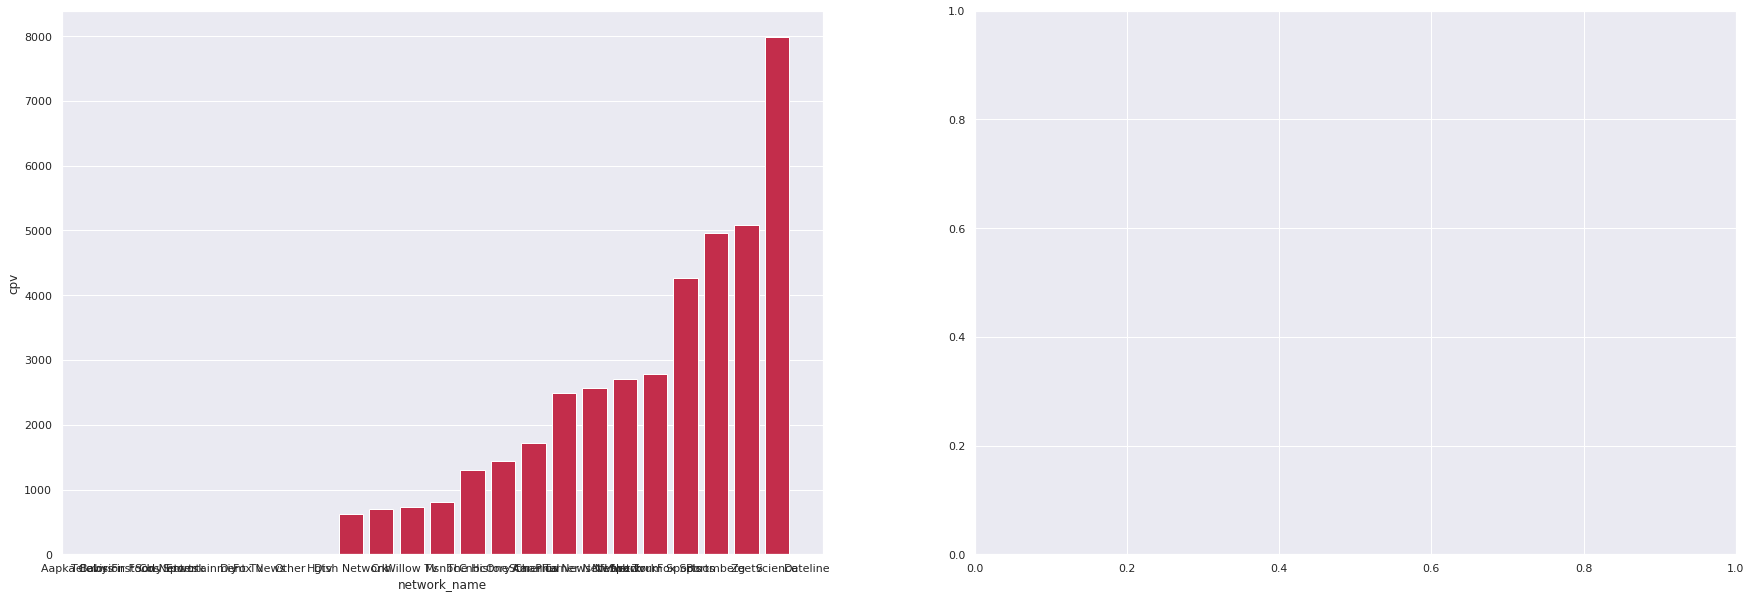

In [787]:
print_visuals(monthly_stats,['cpv','cpa','conversion_rate'])

In [696]:
def print_visuals(df, metrics):
    
    # Get all years in dataset
    years = list(set(df.Year))
    # Get all months in dataset
    months = list(set(df.Month))
    
    for metric in metrics:
        for year in years:
            for month in months:
                print(metric, year, month)
                vis_df = df[(df['Year'] == year) & (df['Month'] == month)]
                vis_df = vis_df.sort_values(metric)
                
                # Set Plot size
                sns.set(rc={'figure.figsize':(20,7.5)})
                sns.barplot(x='network_name',y='cpv', data=vis_df, palette = ['crimson'])
                
                
                # Use Network as labels
                #labels = vis_df.network_name.unique()
                # Label Locations
                #x = np.arange(len(labels))
                # Width of bars
                #width = .15
                # Plot Data
                #fig, ax = plt.subplots()
                #print(type(df[metric]))
                #plt.bar(x,df[metric])
                #rects = ax.bar(x - width/2, metric, width, label=metric)
        
    #    return df[metric]
    
    #return months

cpv 2017 9
cpv 2017 10
cpa 2017 9
cpa 2017 10
conversion_rate 2017 9
conversion_rate 2017 10


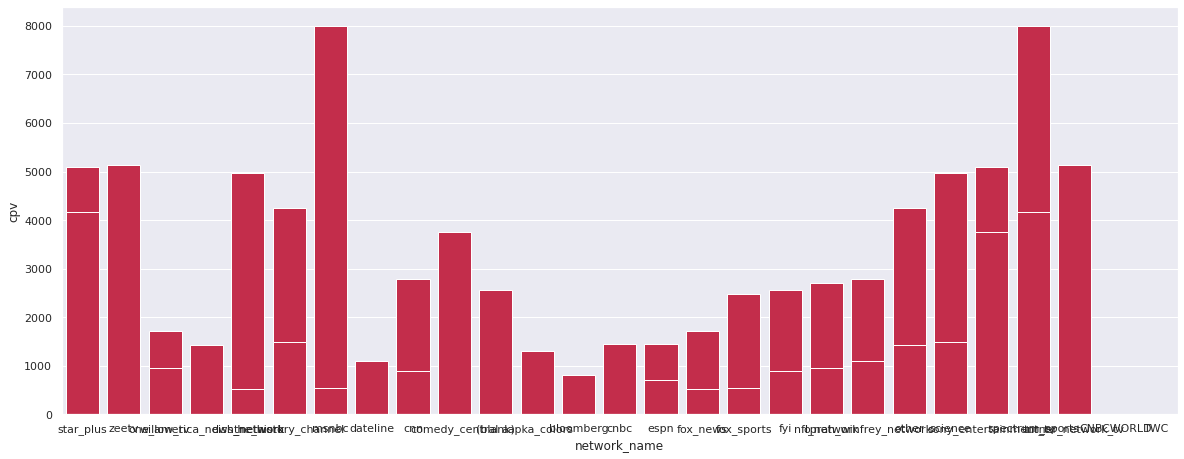

In [687]:
print_visuals(monthly_stats,['cpv','cpa','conversion_rate'])

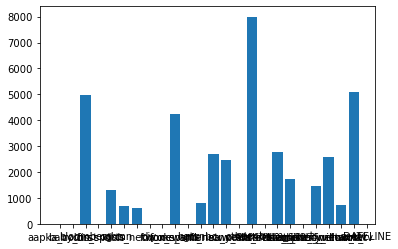

In [648]:
df = monthly_stats
df = df[(df['Year'] == 2017) & (df['Month'] == 9)]
labels = df.network_name.unique()
x = np.arange(len(labels))
fig, ax = plt.subplots()
plt.bar(x, df.cpv)
plt.xticks(x, labels)
plt.show()

In [734]:
df.network_name = df.network_name.map(lambda x: x.replace("_"," "))
df.network_name.map(lambda x: x.title())

0     Aapka Colors            
1     Baby First              
2     Bloomberg               
3     Cbs Sports              
4     Cnbc                    
5     Cnn                     
6     Dish Network            
7     Diy                     
8     Fox News                
9     Fox Sports              
10    Hgtv                    
11    Msnbc                   
12    Nfl Network             
13    One America News Network
14    Other                   
15    Science                 
16    Sony Entertainment Tv   
17    Spectrum Sports         
18    Star Plus               
19    Television Food Network 
20    The History Channel     
21    Turner Network Tv       
22    Willow Tv               
23    Zeetv                   
49    Dateline                
Name: network_name, dtype: object

<AxesSubplot:xlabel='network_name', ylabel='cpv'>

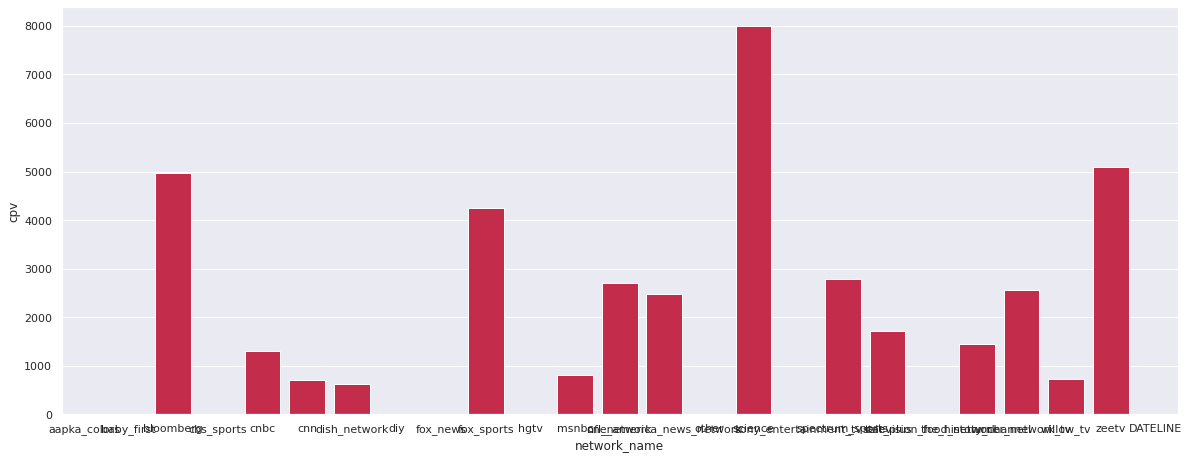

In [657]:

sns.set(rc={'figure.figsize':(20,7.5)})
sns.barplot(x='network_name',y='cpv', data=df, palette = ['crimson'])
#plt.title('Red Wine Quality Count', fontsize=30)
#plt.xlabel('Quality', fontsize=24)
#plt.ylabel('Count', fontsize=24)
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)

In [637]:
df =monthly_stats
labels = df.network_name.unique()
x = np.arange(len(labels))

    # Plot Data
                fig, ax = plt.subplots()
                print(type(df[metric]))

IndentationError: unexpected indent (<ipython-input-637-7430b568c7d1>, line 6)

In [594]:
def compare_months(df,month1,year1,month2,year2,metric):
    # Get number of networks
    df1 = df[(df['Year'] == year1) & (df['Month'] == month1)]
    df2 = df[(df['Year'] == year2) & (df['Month'] == month2)]
    
    networks1 = df1.network_name
    networks2 = df2.network_name
    networks = networks1.append(networks2)
    networks = set(networks1)
    labels = list(networks)
    
    x = np.arange(len(networks))
    width = 0.15
    
    fig, ax = plt.subplots(figsize=(20,6))
    
    rects1 = ax.bar(x - width/2, df1.cpa, label = month1)
    rects2 = ax.bar(x + width/2, df2.cpa, label = month2)
    
    ax.set_ylabel('CPA')
    ax.set_title('CPA by Network')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    

    #pass

ValueError: shape mismatch: objects cannot be broadcast to a single shape

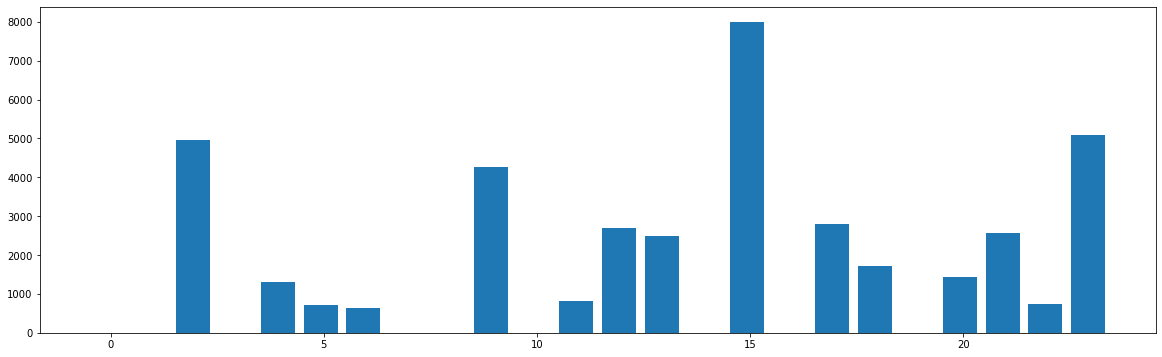

In [595]:
compare_months(monthly_stats,9,2017,10,2017,'cpa')

In [258]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)  # or 199
import datetime as dt
#pd.options.mode.chained_assignment = None 
#import copy
#import numpy as np

<ipython-input-258-269628ef0bd1>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # or 199


In [472]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        # Prepare df3/lookup for use
        
        # Make firt column lowercase
        df3['Exit Survey'] = df3['Exit Survey'].str.lower()
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Purchases'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='outer')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, left_on=['Year','Month','Airings'], right_on=['Year','Month','Network'], how='outer')
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Network','Purchases','Spend','Lift']]
        monthly_stats = monthly_stats[monthly_stats.Year.notna()]
        
        return monthly_stats
    
    def get_metrics(self):
        # Get Monthly Stats Df
        monthly_stats = self.get_monthly_stats()
        
        # Compute Cost Per Visitor
        monthly_stats['cpv'] = monthly_stats['Spend']/monthly_stats['Purchases']
        
        # Compute Conversion Rate 
        monthly_stats['conversion_rate'] = monthly_stats['Purchases']/monthly_stats['Lift']
        
        # Compute Cost Per Acquisition
        monthly_stats['cpa'] = monthly_stats['Spend']/monthly_stats['Purchases']
        
        return monthly_stats
    

In [473]:
test = Final('Analyst_Dataset.xlsx')

In [478]:
df1, df2, df3 = test.prepare_data()

In [479]:
df1.head()

,TV_Network,Year,Quarter,Month,Submitted_Application_Num,Value
0,(blank),2017,Q4,10,14,1.0
1,(blank),2017,Q4,10,29,1.0
2,(blank),2017,Q4,10,8,1.0
3,aapka_colors,2017,Q4,10,1,1.0
4,aapka_colors,2017,Q3,9,11,1.0


In [480]:
# Compute Visits Per Month
df1 = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
df1 = df1.to_frame()
df1 = df1.reset_index()
df1 = df1.rename(columns = {'Value':'Purchases'})
df1.head()

,Year,Quarter,Month,TV_Network,Purchases
0,2017,Q3,9,aapka_colors,1.0
1,2017,Q3,9,baby_first,1.0
2,2017,Q3,9,bloomberg,1.0
3,2017,Q3,9,cbs_sports,1.0
4,2017,Q3,9,cnbc,5.0


In [485]:
df3

,Exit Survey,Airings,Exit Survey.1
0,(blank),NaN,(blank)
1,aapka_colors,NaN,aapka_colors
2,baby_first,BABY,baby_first
3,bloomberg,BLOM,bloomberg
4,cbs_sports,CBSS,cbs_sports
5,cnbc,CNBC,cnbc
6,cnn,CNN,cnn
7,comedy_central,COM,comedy_central
8,cozi,COZI,cozi
9,dateline,DATELINE,Dateline


In [488]:
newdf = pd.merge(df1, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='left')
newdf

,Year,Quarter,Month,TV_Network,Purchases,Exit Survey,Airings
0,2017,Q3,9,aapka_colors,1.0,aapka_colors,NaN
1,2017,Q3,9,baby_first,1.0,baby_first,BABY
2,2017,Q3,9,bloomberg,1.0,bloomberg,BLOM
3,2017,Q3,9,cbs_sports,1.0,cbs_sports,CBSS
4,2017,Q3,9,cnbc,5.0,cnbc,CNBC
5,2017,Q3,9,cnn,13.0,cnn,CNN
6,2017,Q3,9,dish_network,4.0,dish_network,DISH
7,2017,Q3,9,diy,2.0,diy,NaN
8,2017,Q3,9,fox_news,5.0,fox_news,FNEW
9,2017,Q3,9,fox_sports,1.0,fox_sports,FS1


In [489]:
df2.head()

,Company,Datetime,Rotation,Creative,Network,Spend,Lift,Program,Year,Month
0,Company XYZ,2017-10-30 22:50:00,MSNB Weekday Prime,ISCICODE0015H,MSNB,980.0,152,THE LAST WORD WITH LAWRENCE O'DONNEL,2017,10
1,Company XYZ,2017-10-30 22:27:50,HIST Everyday Prime (mirrored),ISCICODE0015H,HIST,1500.0,77,PAWN STARS,2017,10
2,Company XYZ,2017-10-30 21:42:20,TWC Everyday Prime,ISCICODE0015H,TWC,300.0,15,WEATHER HACKS,2017,10
3,Company XYZ,2017-10-30 21:17:22,MSNB Weekday Prime,ISCICODE0015H,MSNB,1020.0,123,THE RACHEL MADDOW SHOW,2017,10
4,Company XYZ,2017-10-30 20:28:46,MSNB Weekday Prime,ISCICODE0015H,MSNB,1020.0,121,ALL IN WITH CHRIS HAYES,2017,10


In [490]:
# Compute Spend and Lift Per Month
df2 = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
df2 = df2.reset_index()
df2

<ipython-input-490-0d24ce739400>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


,Year,Month,Network,Spend,Lift
0,2017,9,BLOM,4966.72,199
1,2017,9,CNBC,6481.42,406
2,2017,9,CNN,9159.60,507
3,2017,9,DATELINE,4211.62,252
4,2017,9,DISH,2513.09,976
5,2017,9,FS1,4258.50,183
6,2017,9,HIST,5778.30,253
7,2017,9,MSNB,8091.15,701
8,2017,9,NFLN,5412.80,200
9,2017,9,OANN,4966.80,648


In [492]:
newdf2 = pd.merge(df2, df3[['Exit Survey','Airings']],left_on= ['Network'], right_on = ['Airings'], how='left')
newdf2

,Year,Month,Network,Spend,Lift,Exit Survey,Airings
0,2017,9,BLOM,4966.72,199,bloomberg,BLOM
1,2017,9,CNBC,6481.42,406,cnbc,CNBC
2,2017,9,CNN,9159.60,507,cnn,CNN
3,2017,9,DATELINE,4211.62,252,dateline,DATELINE
4,2017,9,DISH,2513.09,976,dish_network,DISH
5,2017,9,FS1,4258.50,183,fox_sports,FS1
6,2017,9,HIST,5778.30,253,the_history_channel,HIST
7,2017,9,MSNB,8091.15,701,msnbc,MSNB
8,2017,9,NFLN,5412.80,200,nfl_network,NFLN
9,2017,9,OANN,4966.80,648,one_america_news_network,OANN


In [494]:
newdf.head()

,Year,Quarter,Month,TV_Network,Purchases,Exit Survey,Airings
0,2017,Q3,9,aapka_colors,1.0,aapka_colors,NaN
1,2017,Q3,9,baby_first,1.0,baby_first,BABY
2,2017,Q3,9,bloomberg,1.0,bloomberg,BLOM
3,2017,Q3,9,cbs_sports,1.0,cbs_sports,CBSS
4,2017,Q3,9,cnbc,5.0,cnbc,CNBC


In [495]:
newdf2.head(2)

,Year,Month,Network,Spend,Lift,Exit Survey,Airings
0,2017,9,BLOM,4966.72,199,bloomberg,BLOM
1,2017,9,CNBC,6481.42,406,cnbc,CNBC


In [496]:
pd.merge(newdf,newdf2,on=['Year','Month','Exit Survey'], how='outer')

,Year,Quarter,Month,TV_Network,Purchases,Exit Survey,Airings_x,Network,Spend,Lift,Airings_y
0,2017,Q3,9,aapka_colors,1.0,aapka_colors,NaN,NaN,NaN,NaN,NaN
1,2017,Q3,9,baby_first,1.0,baby_first,BABY,NaN,NaN,NaN,NaN
2,2017,Q3,9,bloomberg,1.0,bloomberg,BLOM,BLOM,4966.72,199.0,BLOM
3,2017,Q3,9,cbs_sports,1.0,cbs_sports,CBSS,NaN,NaN,NaN,NaN
4,2017,Q3,9,cnbc,5.0,cnbc,CNBC,CNBC,6481.42,406.0,CNBC
5,2017,Q3,9,cnn,13.0,cnn,CNN,CNN,9159.60,507.0,CNN
6,2017,Q3,9,dish_network,4.0,dish_network,DISH,DISH,2513.09,976.0,DISH
7,2017,Q3,9,diy,2.0,diy,NaN,NaN,NaN,NaN,NaN
8,2017,Q3,9,fox_news,5.0,fox_news,FNEW,NaN,NaN,NaN,NaN
9,2017,Q3,9,fox_sports,1.0,fox_sports,FS1,FS1,4258.50,183.0,FS1


In [455]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        #df1['Year'] = df['Year'].astype(int)
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        # Prepare df3/lookup for use
        df3['Exit Survey'] = df3['Exit Survey'].str.lower()
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Visits'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='outer')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, left_on=['Year','Month','Airings'], right_on=['Year','Month','Network'], how='left')
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Visits','Spend','Lift']]
        
        return monthly_stats
    
    def get_metrics(self):
        # Get Monthly Stats Df
        monthly_stats = self.get_monthly_stats()
        
        # Compute Cost Per Visitor
        monthly_stats['cpv'] = monthly_stats['Spend']/monthly_stats['Visits']
        
        # Compute Conversion Rate 
        monthly_stats['conversion_rate'] = monthly_stats['Visits']/monthly_stats['Lift']
        
        # Compute Cost Per Acquisition
        monthly_stats['cpa'] = monthly_stats['Spend']/monthly_stats['Visits']
        
        return monthly_stats

In [456]:
test = Final('Analyst_Dataset.xlsx')


In [457]:
df1, df2, df3 = test.prepare_data()
df1.head()

,TV_Network,Year,Quarter,Month,Submitted_Application_Num,Value
0,(blank),2017,Q4,10,14,1.0
1,(blank),2017,Q4,10,29,1.0
2,(blank),2017,Q4,10,8,1.0
3,aapka_colors,2017,Q4,10,1,1.0
4,aapka_colors,2017,Q3,9,11,1.0


In [459]:
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Purchases'})

In [460]:
visits_per_month.head()

,Year,Quarter,Month,TV_Network,Purchases
0,2017,Q3,9,aapka_colors,1.0
1,2017,Q3,9,baby_first,1.0
2,2017,Q3,9,bloomberg,1.0
3,2017,Q3,9,cbs_sports,1.0
4,2017,Q3,9,cnbc,5.0


In [461]:
visits_per_month.TV_Network.nunique()

30

In [462]:
# Merge visits_per_month to Lookup Table
visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='outer')

In [463]:
visits_per_month

,Year,Quarter,Month,TV_Network,Purchases,Exit Survey,Airings
0,2017.0,Q3,9.0,aapka_colors,1.0,aapka_colors,NaN
1,2017.0,Q4,10.0,aapka_colors,5.0,aapka_colors,NaN
2,2017.0,Q3,9.0,baby_first,1.0,baby_first,BABY
3,2017.0,Q3,9.0,bloomberg,1.0,bloomberg,BLOM
4,2017.0,Q4,10.0,bloomberg,1.0,bloomberg,BLOM
5,2017.0,Q3,9.0,cbs_sports,1.0,cbs_sports,CBSS
6,2017.0,Q3,9.0,cnbc,5.0,cnbc,CNBC
7,2017.0,Q4,10.0,cnbc,10.0,cnbc,CNBC
8,2017.0,Q3,9.0,cnn,13.0,cnn,CNN
9,2017.0,Q4,10.0,cnn,10.0,cnn,CNN


In [466]:
# Compute Spend and Lift Per Month
lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
lift_spend_df = lift_spend_df.reset_index()
lift_spend_df

<ipython-input-466-cddbd7026655>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


,Year,Month,Network,Spend,Lift
0,2017,9,BLOM,4966.72,199
1,2017,9,CNBC,6481.42,406
2,2017,9,CNN,9159.60,507
3,2017,9,DATELINE,4211.62,252
4,2017,9,DISH,2513.09,976
5,2017,9,FS1,4258.50,183
6,2017,9,HIST,5778.30,253
7,2017,9,MSNB,8091.15,701
8,2017,9,NFLN,5412.80,200
9,2017,9,OANN,4966.80,648


In [437]:
visits_per_month.Airings.nunique()

24

In [440]:
df2.Network.unique()

array(['MSNB', 'HIST', 'TWC', 'WILO', 'STARPLUS', 'ZEETV', 'OANN', 'CNN',
       'CNBCWORLD', 'DATELINE', 'COM', 'DISH', 'BLOM', 'NFLN', 'FS1',
       'TNT', 'CNBC', 'SPECSPTS', 'SCI'], dtype=object)

In [452]:
df[df2.Network == 'TWC']

,Company,Datetime,Rotation,Creative,Network,Spend,Lift,Program,Year,Month
2,Company XYZ,2017-10-30 21:42:20,TWC Everyday Prime,ISCICODE0015H,TWC,300.00,15,WEATHER HACKS,2017,10
26,Company XYZ,2017-10-29 21:40:46,TWC Everyday Prime,ISCICODE0015H,TWC,510.00,-1,LIVE STORM COVERAGE,2017,10
33,Company XYZ,2017-10-29 20:40:32,TWC Everyday Prime,ISCICODE0015H,TWC,500.00,-9,LIVE STORM COVERAGE,2017,10
123,Company XYZ,2017-10-28 20:41:01,TWC Everyday Prime,ISCICODE0015H,TWC,510.00,6,LIVE STORM COVERAGE,2017,10
124,Company XYZ,2017-10-28 19:16:17,TWC Everyday Prime,ISCICODE0015H,TWC,500.00,9,LIVE STORM COVERAGE,2017,10
174,Company XYZ,2017-10-27 20:28:36,TWC Everyday Prime,ISCICODE0015H,TWC,500.00,-7,WEATHER CAUGHT ON CAMERA,2017,10
177,Company XYZ,2017-10-27 19:27:07,TWC Everyday Prime,ISCICODE0015H,TWC,500.00,9,WEATHER UNDERGROUND,2017,10
234,Company XYZ,2017-10-26 21:28:25,TWC Everyday Prime,ISCICODE0015H,TWC,510.00,18,WEATHER GONE VIRAL,2017,10
249,Company XYZ,2017-10-26 19:09:35,TWC Everyday Prime,ISCICODE0015H,TWC,490.00,-19,WEATHER UNDERGROUND,2017,10
300,Company XYZ,2017-10-25 20:09:57,TWC Everyday Prime,ISCICODE0015H,TWC,500.00,40,WEATHER CAUGHT ON CAMERA,2017,10


In [451]:
df[df2.Network == 'CNBC']

,Company,Datetime,Rotation,Creative,Network,Spend,Lift,Program,Year,Month
6112,Company XYZ,2017-09-10 19:21:44,CNBC Everyday Prime,ISCICODE0015H,CNBC,708.05,4,SHARK TANK,2017,9
6291,Company XYZ,2017-09-05 18:51:24,CNBC Weekday Day,ISCICODE0015H,CNBC,208.08,9,MAD MONEY,2017,9
6295,Company XYZ,2017-09-05 17:58:34,CNBC Weekday Day,ISCICODE0015H,CNBC,208.08,4,FAST MONEY,2017,9
6330,Company XYZ,2017-09-04 16:19:20,CNBC Weekday Day,ISCICODE0015H,CNBC,208.08,18,SHARK TANK,2017,9
6339,Company XYZ,2017-09-04 09:43:28,CNBC Weekday Day,ISCICODE0015H,CNBC,199.92,29,AMERICAN GREED,2017,9
6341,Company XYZ,2017-09-04 09:16:32,CNBC Weekday Day,ISCICODE0015H,CNBC,199.92,15,AMERICAN GREED,2017,9
6343,Company XYZ,2017-09-04 07:52:44,CNBC Weekday Day,ISCICODE0015H,CNBC,199.92,18,>>>> Show Information Not Available <<<<,2017,9
6344,Company XYZ,2017-09-04 06:32:42,CNBC Weekday Day,ISCICODE0015H,CNBC,199.92,20,>>>> Show Information Not Available <<<<,2017,9
6345,Company XYZ,2017-09-03 22:55:54,CNBC Everyday Prime,ISCICODE0015H,CNBC,722.50,81,SHARK TANK,2017,9
6346,Company XYZ,2017-09-03 22:19:20,CNBC Everyday Prime,ISCICODE0015H,CNBC,736.95,44,SHARK TANK,2017,9


In [468]:
monthly_stats = pd.merge(visits_per_month, lift_spend_df, left_on=['Year','Month','Airings'], right_on=['Year','Month','Network'], how='outer')
monthly_stats

,Year,Quarter,Month,TV_Network,Purchases,Exit Survey,Airings,Network,Spend,Lift
0,2017.0,Q3,9.0,aapka_colors,1.0,aapka_colors,NaN,NaN,NaN,NaN
1,2017.0,Q3,9.0,diy,2.0,diy,NaN,NaN,NaN,NaN
2,2017.0,Q3,9.0,other,5.0,other,NaN,NaN,NaN,NaN
3,2017.0,Q3,9.0,sony_entertainment_tv,2.0,sony_entertainment_tv,NaN,NaN,NaN,NaN
4,2017.0,Q4,10.0,aapka_colors,5.0,aapka_colors,NaN,NaN,NaN,NaN
5,2017.0,Q4,10.0,other,8.0,other,NaN,NaN,NaN,NaN
6,2017.0,Q4,10.0,sony_entertainment_tv,2.0,sony_entertainment_tv,NaN,NaN,NaN,NaN
7,2017.0,Q4,10.0,(blank),3.0,(blank),NaN,NaN,NaN,NaN
8,2017.0,Q3,9.0,baby_first,1.0,baby_first,BABY,NaN,NaN,NaN
9,2017.0,Q3,9.0,bloomberg,1.0,bloomberg,BLOM,BLOM,4966.72,199.0


In [471]:
monthly_stats[monthly_stats.Year.notna()]

,Year,Quarter,Month,TV_Network,Purchases,Exit Survey,Airings,Network,Spend,Lift
0,2017.0,Q3,9.0,aapka_colors,1.0,aapka_colors,NaN,NaN,NaN,NaN
1,2017.0,Q3,9.0,diy,2.0,diy,NaN,NaN,NaN,NaN
2,2017.0,Q3,9.0,other,5.0,other,NaN,NaN,NaN,NaN
3,2017.0,Q3,9.0,sony_entertainment_tv,2.0,sony_entertainment_tv,NaN,NaN,NaN,NaN
4,2017.0,Q4,10.0,aapka_colors,5.0,aapka_colors,NaN,NaN,NaN,NaN
5,2017.0,Q4,10.0,other,8.0,other,NaN,NaN,NaN,NaN
6,2017.0,Q4,10.0,sony_entertainment_tv,2.0,sony_entertainment_tv,NaN,NaN,NaN,NaN
7,2017.0,Q4,10.0,(blank),3.0,(blank),NaN,NaN,NaN,NaN
8,2017.0,Q3,9.0,baby_first,1.0,baby_first,BABY,NaN,NaN,NaN
9,2017.0,Q3,9.0,bloomberg,1.0,bloomberg,BLOM,BLOM,4966.72,199.0


In [422]:
monthly_stats = test.get_metrics()
monthly_stats

<ipython-input-420-55961030a641>:56: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


,Year,Quarter,Month,TV_Network,Visits,Spend,Lift,cpv,conversion_rate,cpa
0,2017,Q3,9,aapka_colors,1,NaN,NaN,NaN,NaN,NaN
1,2017,Q3,9,baby_first,1,NaN,NaN,NaN,NaN,NaN
2,2017,Q3,9,bloomberg,1,4966.72,199.0,4966.720000,0.005025,4966.720000
3,2017,Q3,9,cbs_sports,1,NaN,NaN,NaN,NaN,NaN
4,2017,Q3,9,cnbc,4,6481.42,406.0,1620.355000,0.009852,1620.355000
5,2017,Q3,9,cnn,6,9159.60,507.0,1526.600000,0.011834,1526.600000
6,2017,Q3,9,dish_network,3,2513.09,976.0,837.696667,0.003074,837.696667
7,2017,Q3,9,diy,2,NaN,NaN,NaN,NaN,NaN
8,2017,Q3,9,fox_news,4,NaN,NaN,NaN,NaN,NaN
9,2017,Q3,9,fox_sports,1,4258.50,183.0,4258.500000,0.005464,4258.500000


In [412]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        #df1['Year'] = df['Year'].astype(int)
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].count()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Visits'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='outer')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, left_on=['Year','Month','Airings'], right_on=['Year','Month','Network'], how='outer')
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Visits','Spend','Lift']]
        
        return monthly_stats
    
    def get_metrics(self):
        # Get Monthly Stats Df
        monthly_stats = self.get_monthly_stats()
        
        cpv_df = self.get_cpv(monthly_stats)
        return cpv_df
    
    def get_cpv(self, monthly_stats):
        
        return monthly_stats

In [413]:
test = Final('Analyst_Dataset.xlsx')


In [414]:
cpv = test.get_metrics()

<ipython-input-412-ad86e75c008e>:56: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


In [415]:
cpv.head()

,Year,Quarter,Month,TV_Network,Visits,Spend,Lift
0,2017.0,Q3,9.0,aapka_colors,1.0,NaN,NaN
1,2017.0,Q3,9.0,diy,2.0,NaN,NaN
2,2017.0,Q3,9.0,other,5.0,NaN,NaN
3,2017.0,Q3,9.0,sony_entertainment_tv,2.0,NaN,NaN
4,2017.0,Q4,10.0,aapka_colors,4.0,NaN,NaN


In [417]:
cpv.size

476

In [419]:
cpv['cpv'] = cpv['Spend']/cpv['Visits']
cpv

,Year,Quarter,Month,TV_Network,Visits,Spend,Lift,cpv
0,2017.0,Q3,9.0,aapka_colors,1.0,NaN,NaN,NaN
1,2017.0,Q3,9.0,diy,2.0,NaN,NaN,NaN
2,2017.0,Q3,9.0,other,5.0,NaN,NaN,NaN
3,2017.0,Q3,9.0,sony_entertainment_tv,2.0,NaN,NaN,NaN
4,2017.0,Q4,10.0,aapka_colors,4.0,NaN,NaN,NaN
5,2017.0,Q4,10.0,other,6.0,NaN,NaN,NaN
6,2017.0,Q4,10.0,sony_entertainment_tv,2.0,NaN,NaN,NaN
7,2017.0,Q4,10.0,(blank),3.0,NaN,NaN,NaN
8,2017.0,Q4,10.0,dateline,5.0,NaN,NaN,NaN
9,2017.0,Q3,9.0,baby_first,1.0,NaN,NaN,NaN


In [401]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        #df1['Year'] = df['Year'].astype(int)
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].count()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Visits'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='left')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, left_on=['Year','Month','Airings'], right_on=['Year','Month','Network'], how='left')
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Visits','Spend','Lift']]
        
        return monthly_stats
    
    def get_cpv():
        pass

In [402]:
test = Final('Analyst_Dataset.xlsx')

In [403]:
df1,df2,df3 = test.prepare_data()

In [404]:
df2.head()

,Company,Datetime,Rotation,Creative,Network,Spend,Lift,Program,Year,Month
0,Company XYZ,2017-10-30 22:50:00,MSNB Weekday Prime,ISCICODE0015H,MSNB,980.0,152,THE LAST WORD WITH LAWRENCE O'DONNEL,2017,10
1,Company XYZ,2017-10-30 22:27:50,HIST Everyday Prime (mirrored),ISCICODE0015H,HIST,1500.0,77,PAWN STARS,2017,10
2,Company XYZ,2017-10-30 21:42:20,TWC Everyday Prime,ISCICODE0015H,TWC,300.0,15,WEATHER HACKS,2017,10
3,Company XYZ,2017-10-30 21:17:22,MSNB Weekday Prime,ISCICODE0015H,MSNB,1020.0,123,THE RACHEL MADDOW SHOW,2017,10
4,Company XYZ,2017-10-30 20:28:46,MSNB Weekday Prime,ISCICODE0015H,MSNB,1020.0,121,ALL IN WITH CHRIS HAYES,2017,10


In [405]:
df2.loc[df2['Network'] == 'BLOM']


,Company,Datetime,Rotation,Creative,Network,Spend,Lift,Program,Year,Month
5439,Company XYZ,2017-09-22 23:58:55,BLOM Weekday Prime,ISCICODE0015H,BLOM,95.37,-4,BLOOMBERG TECHNOLOGY,2017,9
5441,Company XYZ,2017-09-22 23:27:39,BLOM Weekday Prime,ISCICODE0015H,BLOM,93.50,7,BLOOMBERG TECHNOLOGY,2017,9
5445,Company XYZ,2017-09-22 22:39:50,BLOM Weekday Prime,ISCICODE0015H,BLOM,95.37,-2,CHARLIE ROSE,2017,9
5448,Company XYZ,2017-09-22 21:28:24,BLOM Weekday Prime,ISCICODE0015H,BLOM,95.37,-4,BRILLIANT IDEAS,2017,9
5453,Company XYZ,2017-09-22 20:52:40,BLOM Weekday Prime,ISCICODE0015H,BLOM,93.50,12,BLOOMBERG BEST: GLOBAL BUSINESS FORU,2017,9
5458,Company XYZ,2017-09-22 20:22:39,BLOM Weekday Prime,ISCICODE0015H,BLOM,93.50,-6,BLOOMBERG BEST: GLOBAL BUSINESS FORU,2017,9
5462,Company XYZ,2017-09-22 19:43:10,BLOM Weekday Prime,ISCICODE0015H,BLOM,95.37,-5,BEST OF BLOOMBERG MARKETS: MIDDLE EA,2017,9
5468,Company XYZ,2017-09-22 18:58:24,BLOM Weekday Prime,ISCICODE0015H,BLOM,91.63,-7,CHARLIE ROSE,2017,9
5471,Company XYZ,2017-09-22 18:18:40,BLOM Weekday Prime,ISCICODE0015H,BLOM,93.50,15,CHARLIE ROSE,2017,9
5474,Company XYZ,2017-09-22 17:50:02,BLOM Weekday Prime,ISCICODE0015H,BLOM,93.50,-13,BLOOMBERG TECHNOLOGY,2017,9


In [390]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        #return df1.reset_index()
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        
        
        # Change Year to Int
        df1['Year'] = df['Year'].astype(int)
        
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        
        
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        return df1, df2, df3

In [391]:
test = Final('Analyst_Dataset.xlsx')
df1, df2, df3  = test.prepare_data()

In [396]:
cpv_df1 = df1.groupby(['Year','Quarter','Month','Network'])['Value'].count()
cpv_df1 = cpv_df1.to_frame()
cpv_df1 = cpv_df1.reset_index()
cpv_df1 = cpv_df1.rename(columns = {'Value':'Visits'})
cpv_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     49 non-null     int64 
 1   Quarter  49 non-null     object
 2   Month    49 non-null     int64 
 3   Network  49 non-null     object
 4   Visits   49 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


In [397]:
cpv_df1

,Year,Quarter,Month,Network,Visits
0,2017,Q3,9,aapka_colors,1
1,2017,Q3,9,baby_first,1
2,2017,Q3,9,bloomberg,1
3,2017,Q3,9,cbs_sports,1
4,2017,Q3,9,cnbc,4
5,2017,Q3,9,cnn,6
6,2017,Q3,9,dish_network,3
7,2017,Q3,9,diy,2
8,2017,Q3,9,fox_news,4
9,2017,Q3,9,fox_sports,1


In [392]:
df1.head()

,Network,Year,Quarter,Month,Submitted_Application_Num,Value
0,(blank),2017,Q4,10,14,1.0
1,(blank),2017,Q4,10,29,1.0
2,(blank),2017,Q4,10,8,1.0
3,aapka_colors,2017,Q4,10,1,1.0
4,aapka_colors,2017,Q3,9,11,1.0


In [393]:
cpv_df1 = df2.groupby(['Year','Month','Network'])['Spend','Lift'].sum()
cpv_df1 = cpv_df1.reset_index()
cpv_df1.info()

KeyError: 'Quarter'

In [362]:
cpv_df2 = df1.groupby(['Year','Month','Network'])['Value'].count()
cpv_df2 = cpv_df2.to_frame()
cpv_df2 = cpv_df2.reset_index()
cpv_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     49 non-null     int64 
 1   Month    49 non-null     int64 
 2   Network  49 non-null     object
 3   Value    49 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.7+ KB


In [293]:
cpv_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     28 non-null     int64  
 1   Month    28 non-null     int64  
 2   Network  28 non-null     object 
 3   Spend    28 non-null     float64
 4   Lift     28 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.2+ KB


In [365]:
cpv_df1.head()

,Year,Month,Network,Spend,Lift
0,2017,9,BLOM,4966.72,199
1,2017,9,CNBC,6481.42,406
2,2017,9,CNN,9159.60,507
3,2017,9,DATELINE,4211.62,252
4,2017,9,DISH,2513.09,976


In [366]:
cpv_df2.head()

,Year,Month,Network,Value
0,2017,9,aapka_colors,1
1,2017,9,baby_first,1
2,2017,9,bloomberg,1
3,2017,9,cbs_sports,1
4,2017,9,cnbc,4


In [374]:
df3.head()

,Exit Survey,Airings,Exit Survey.1
0,(blank),NaN,(blank)
1,aapka_colors,NaN,aapka_colors
2,baby_first,BABY,baby_first
3,bloomberg,BLOM,bloomberg
4,cbs_sports,CBSS,cbs_sports


In [400]:
new_df = pd.merge(cpv_df2, df3['Airings', 'Exit Survey'], left_on= ['Network'], right_on = ['Exit Survey'], how='left')
new_df.head()

KeyError: ('Airings', 'Exit Survey')

In [386]:
new_df = pd.merge(new_df, cpv_df1, left_on=['Year','Month','Airings'], right_on=['Year','Month','Network'],how='left')
new_df.head()

,Year,Month,Network_x,Value,Exit Survey,Airings,Exit Survey.1,Network_y,Spend,Lift
0,2017,9,aapka_colors,1,aapka_colors,NaN,aapka_colors,NaN,NaN,NaN
1,2017,9,baby_first,1,baby_first,BABY,baby_first,NaN,NaN,NaN
2,2017,9,bloomberg,1,bloomberg,BLOM,bloomberg,BLOM,4966.72,199.0
3,2017,9,cbs_sports,1,cbs_sports,CBSS,cbs_sports,NaN,NaN,NaN
4,2017,9,cnbc,4,cnbc,CNBC,cnbc,CNBC,6481.42,406.0


In [ ]:
new_df = new_df[[Year]]

In [ ]:
new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])


In [364]:
cpv_df2.merge(cpv_df1, how='left', on= ['Year','Month', 'Network'])

,Year,Month,Network,Value,Spend,Lift
0,2017,9,aapka_colors,1,NaN,NaN
1,2017,9,baby_first,1,NaN,NaN
2,2017,9,bloomberg,1,NaN,NaN
3,2017,9,cbs_sports,1,NaN,NaN
4,2017,9,cnbc,4,NaN,NaN
5,2017,9,cnn,6,NaN,NaN
6,2017,9,dish_network,3,NaN,NaN
7,2017,9,diy,2,NaN,NaN
8,2017,9,fox_news,4,NaN,NaN
9,2017,9,fox_sports,1,NaN,NaN


In [267]:
df.groupby(['Year','Month','Network'])['Spend','Lift'].sum()

<ipython-input-267-d2dd875b0b8b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Year','Month','Network'])['Spend','Lift'].sum()


Spend  Lift
Year Month Network                  
2017 9     BLOM       4966.72   199 
           CNBC       6481.42   406 
           CNN        9159.60   507 
           DATELINE   4211.62   252 
           DISH       2513.09   976 
           FS1        4258.50   183 
           HIST       5778.30   253 
           MSNB       8091.15   701 
           NFLN       5412.80   200 
           OANN       4966.80   648 
           SCI        7993.18   132 
           SPECSPTS   5580.26   220 
           STARPLUS   3441.58   562 
           TNT        5125.50   179 
           WILO       19773.49  3138
           ZEETV      10175.13  922 
     10    CNBCWORLD  1299.99   51  
           CNN        8954.75   574 
           COM        7501.25   108 
           DATELINE   11076.49  610 
           DISH       520.24    116 
           HIST       1500.00   77  
           MSNB       3238.89   422 
           OANN       19968.20  1724
           STARPLUS   8338.98   1221
           TWC        7718.71   211 
           WILO       27961.08  5076
           ZEETV      15429.12  819

In [180]:
df = pd.read_excel('Analyst_Dataset.xlsx', header=[0,1,2,3,4], index_col=[0,1])
#df = df.fillna(0)
df.head()

Submitted Application Timestamp                   \
                                                      2017                    
                                                        Q3                    
                                                 September                    
Source                                                   2    3   4   5   6   
tv_commercial (blank)                                  NaN  NaN NaN NaN NaN   
              aapka_colors                             NaN  NaN NaN NaN NaN   
              baby_first                               NaN  NaN NaN NaN NaN   
              bloomberg                                NaN  NaN NaN NaN NaN   
              cbs_sports                               NaN  1.0 NaN NaN NaN   

                                                                             \
                                                                              
                                                                              
                                                                              
Source                       7   8  10   11  12  13  14  15  16  17  18  19   
tv_commercial (blank)      NaN NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
              aapka_colors NaN NaN NaN  1.0 NaN NaN NaN NaN NaN NaN NaN NaN   
              baby_first   NaN NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
              bloomberg    NaN NaN NaN  1.0 NaN NaN NaN NaN NaN NaN NaN NaN   
              cbs_sports   NaN NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   

                                                                             \
                                                                              
                                                                         Q4   
                                                                    October   
Source                      21  22  23  24   25  26  27  28  29  30       1   
tv_commercial (blank)      NaN NaN NaN NaN  NaN NaN NaN NaN NaN NaN     NaN   
              aapka_colors NaN NaN NaN NaN  NaN NaN NaN NaN NaN NaN     1.0   
              baby_first   NaN NaN NaN NaN  1.0 NaN NaN NaN NaN NaN     NaN   
              bloomberg    NaN NaN NaN NaN  NaN NaN NaN NaN NaN NaN     NaN   
              cbs_sports   NaN NaN NaN NaN  NaN NaN NaN NaN NaN NaN     NaN   

                                                                           \
                                                                            
                                                                            
                                                                            
Source                        2   3   4   5   7    8   9  10   11  12  13   
tv_commercial (blank)       NaN NaN NaN NaN NaN  1.0 NaN NaN  NaN NaN NaN   
              aapka_colors  1.0 NaN NaN NaN NaN  NaN NaN NaN  NaN NaN NaN   
              baby_first    NaN NaN NaN NaN NaN  NaN NaN NaN  NaN NaN NaN   
              bloomberg     NaN NaN NaN NaN NaN  NaN NaN NaN  1.0 NaN NaN   
              cbs_sports    NaN NaN NaN NaN NaN  NaN NaN NaN  NaN NaN NaN   

                                                                               \
                                                                                
                                                                                
                                                                                
Source                       14  15   16  17  18  19  20  21  22   23  24  25   
tv_commercial (blank)       1.0 NaN  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   
              aapka_colors  NaN NaN  1.0 NaN NaN NaN NaN NaN NaN  2.0 NaN NaN   
              baby_first    NaN NaN  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   
              bloomberg     NaN NaN  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   
              cbs_sports    NaN NaN  NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN   

                                                 
                      

In [181]:
df = df.stack().stack().stack().stack()
df.head()

Submitted Application Timestamp
                           Source                                                   
tv_commercial (blank)      14     October   Q4 2017                              1.0
                           29     October   Q4 2017                              1.0
                           8      October   Q4 2017                              1.0
              aapka_colors 1      October   Q4 2017                              1.0
                           11     September Q3 2017                              1.0

In [182]:
#df.index.set_names(['Year','hi'],level=[2,len(df.index.names)-2],inplace=True)
df.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
df = df.reset_index()
df = df.rename(columns={'Submitted Application Timestamp':'Value'})
df = df[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]

In [183]:
df

,TV_Network,Year,Quarter,Month,Submitted_Application_Num,Value
0,(blank),2017,Q4,October,14,1.0
1,(blank),2017,Q4,October,29,1.0
2,(blank),2017,Q4,October,8,1.0
3,aapka_colors,2017,Q4,October,1,1.0
4,aapka_colors,2017,Q3,September,11,1.0
5,aapka_colors,2017,Q4,October,16,1.0
6,aapka_colors,2017,Q4,October,2,1.0
7,aapka_colors,2017,Q4,October,23,2.0
8,baby_first,2017,Q3,September,25,1.0
9,bloomberg,2017,Q4,October,11,1.0


In [192]:
class GetData(object):
    
    def __init__(self):
        pass
    
    def read_excel(self, excel_file):
        purchase_exit_survey_data_df = pd.read_excel(excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        return purchase_exit_survey_data_df
    
    def clean_purchase_exit_survey_data(self, df):
        return df
    
    def prepare_data(self, excel_file):
        purchase_exit_survey_data_df = read_excel(excel_file)
        clean_purchase_exit_survey_data(df)
        
        
    

In [193]:
x = GetData()

In [194]:
x.prepare_data('Analyst_Dataset.xlsx')

NameError: name 'read_excel' is not defined

In [230]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file
    
    def read_excel(self, excel_file):
        purchase_exit_survey_data_df = pd.read_excel(excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])
        airings_df = pd.read_excel('Analyst_Dataset.xlsx', sheet_name = 'Airings')
        lookup_df = pd.read_excel('Analyst_Dataset.xlsx', sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def clean_purchase_exit_survey_data(self, excel_file):
        df1, df2, df3 = read_excel(excel_file)
        #df1 = df1.stack().stack().stack().stack()
        #df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        #df1 = df1.reset_index()
        #df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        #df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        return 'hi'
    

In [231]:
report = Final()

AttributeError: 'Final' object has no attribute 'excel_file'

In [229]:
clean_purchase_exit_survey_data('Analyst_Dataset.xlsx')

Submitted Application Timestamp       \
                                                                  2017        
                                                                    Q3        
                                                             September        
Source                                                               2    3   
tv_commercial (blank)                                              NaN  NaN   
              aapka_colors                                         NaN  NaN   
              baby_first                                           NaN  NaN   
              bloomberg                                            NaN  NaN   
              cbs_sports                                           NaN  1.0   
              cnbc                                                 NaN  1.0   
              cnn                                                  NaN  NaN   
              comedy_central                                       NaN  NaN   
              dateline                                             NaN  NaN   
              dish_network                                         NaN  NaN   
              diy                                                  NaN  NaN   
              espn                                                 NaN  NaN   
              fox_news                                             NaN  NaN   
              fox_sports                                           NaN  NaN   
              fyi                                                  NaN  NaN   
              hgtv                                                 NaN  NaN   
              msnbc                                                NaN  NaN   
              nfl_network                                          NaN  NaN   
              one_america_news_network                             NaN  NaN   
              oprah_winfrey_network                                NaN  NaN   
              other                                                NaN  NaN   
              science                                              1.0  NaN   
              sony_entertainment_tv                                NaN  NaN   
              spectrum_sports                                      NaN  NaN   
              star_plus                                            NaN  NaN   
              television_food_network                              1.0  NaN   
              the_history_channel                                  NaN  NaN   
              turner_network_tv                                    NaN  NaN   
              willow_tv                                            NaN  4.0   
              zeetv                                                NaN  NaN   

                                                                           \
                                                                            
                                                                            
                                                                            
Source                                    4    5    6    7    8   10   11   
tv_commercial (blank)                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              aapka_colors              NaN  NaN  NaN  NaN  NaN  NaN  1.0   
              baby_first                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              bloomberg                 NaN  NaN  NaN  NaN  NaN  NaN  1.0   
              cbs_sports                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              cnbc                      1.0  NaN  NaN  NaN  2.0  NaN  NaN   
              cnn                       3.0  NaN  NaN  3.0  3.0  NaN  NaN   
              comedy_central            NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              dateline                  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              dish_network              NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              diy                       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              espn                      N

In [195]:
#df = pd.read_excel('Analyst_Dataset.xlsx', sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1])


In [206]:
df = pd.read_excel('Analyst_Dataset.xlsx', sheet_name = 'Lookup',header=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Exit Survey    43 non-null     object
 1   Airings        38 non-null     object
 2   Exit Survey.1  43 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


In [207]:
df.head()

,Exit Survey,Airings,Exit Survey.1
0,(blank),NaN,(blank)
1,aapka_colors,NaN,aapka_colors
2,baby_first,BABY,baby_first
3,bloomberg,BLOM,bloomberg
4,cbs_sports,CBSS,cbs_sports


In [203]:
df.stack()

0   Lookup table for survey response field to airings network ticker symbol                 Exit Survey
    Unnamed: 1                                                                                  Airings
    Unnamed: 2                                                                              Exit Survey
1   Lookup table for survey response field to airings network ticker symbol                     (blank)
    Unnamed: 2                                                                                  (blank)
2   Lookup table for survey response field to airings network ticker symbol                aapka_colors
    Unnamed: 2                                                                             aapka_colors
3   Lookup table for survey response field to airings network ticker symbol                  baby_first
    Unnamed: 1                                                                                     BABY
    Unnamed: 2                                                  

In [67]:
df.melt()

,variable,value
0,Submitted Application Timestamp,1.0
1,Submitted Application Timestamp,1.0
2,Submitted Application Timestamp,1.0
3,Submitted Application Timestamp,1.0
4,Submitted Application Timestamp,1.0
5,Submitted Application Timestamp,1.0
6,Submitted Application Timestamp,1.0
7,Submitted Application Timestamp,2.0
8,Submitted Application Timestamp,1.0
9,Submitted Application Timestamp,1.0


In [34]:
df.columns.tolist()

[('Unnamed: 1_level_0',
  'Unnamed: 1_level_1',
  'Unnamed: 1_level_2',
  'Unnamed: 1_level_3',
  'Source'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '2'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '3'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '4'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '5'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '6'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '7'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '8'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '10'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '11'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '12'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '13'),
 ('Submitted Application Timestamp', '2017', 'Q3', 'September', '14'),
 ('Submitted Application Timestamp', '2017', '

In [71]:
pd.melt(df, value_vars = df.columns.tolist())

,variable,value
0,Submitted Application Timestamp,1.0
1,Submitted Application Timestamp,1.0
2,Submitted Application Timestamp,1.0
3,Submitted Application Timestamp,1.0
4,Submitted Application Timestamp,1.0
5,Submitted Application Timestamp,1.0
6,Submitted Application Timestamp,1.0
7,Submitted Application Timestamp,2.0
8,Submitted Application Timestamp,1.0
9,Submitted Application Timestamp,1.0


In [70]:
pd.melt(df, col_level=1)

IndexError: Too many levels: Index has only 1 level, not 2

In [68]:
df1 = pd.melt(df, id_vars = ['Unnamed: 1'],var_name = 'Year', var_name='Submitted_Timestamp_App' )
df1.head()

SyntaxError: keyword argument repeated (<ipython-input-68-18fedc1bd2a4>, line 1)